# Human Activity Recognition (HAR) Project

**Goal:** Train and evaluate machine learning models for human activity recognition based on physiological and motion sensor data from the provided dataset. This is a multi-class classification problem.

**Note:** This analysis is currently performed only on **Subject 101** (Training) and **Subject 102** (Testing) due to the unavailability of the remaining seven data files. The final model performance will be significantly better and more robust when all nine subjects are included.

## 1. Setup and Data Loading

We define the column names and activity labels based on the project description and create a function to load and preprocess the data.

In [6]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Column Definitions ---
IMU_COLUMNS = [
    'temp',
    'accel_16g_x', 'accel_16g_y', 'accel_16g_z', 
    'accel_6g_x', 'accel_6g_y', 'accel_6g_z',   
    'gyro_x', 'gyro_y', 'gyro_z',               
    'mag_x', 'mag_y', 'mag_z',                  
    'orient_1', 'orient_2', 'orient_3', 'orient_4' 
]

COLUMNS = [
    'timestamp',
    'activity_id',
    'heart_rate',
]
for location in ['hand', 'chest', 'ankle']:
    COLUMNS.extend([f'{location}_{col}' for col in IMU_COLUMNS])

# --- 2. Activity Mapping ---
ACTIVITY_LABELS = {
    1: 'Lying', 2: 'Sitting', 3: 'Standing', 4: 'Walking', 5: 'Running',
    6: 'Cycling', 7: 'Nordic walking', 9: 'Watching TV', 10: 'Computer work',
    11: 'Car driving', 12: 'Ascending stairs', 13: 'Descending stairs',
    16: 'Vacuum cleaning', 17: 'Ironing', 18: 'Folding laundry',
    19: 'House cleaning', 20: 'Playing soccer', 24: 'Rope jumping',
    0: 'Transient' 
}

# --- 3. Data Loading Function ---
def load_har_data(file_paths):
    """
    Loads, merges, and performs initial preprocessing on the HAR data files.
    """
    all_data = []
    
    for file_path in file_paths:
        try:
            subject_id = int(os.path.basename(file_path).split('subject')[1].split('.')[0])
            df = pd.read_csv(file_path, sep=' ', header=None, names=COLUMNS, na_values=['NaN'])
            df['subject_id'] = subject_id
            all_data.append(df)
            print(f"Successfully loaded data for Subject {subject_id}")
            
        except FileNotFoundError:
            print(f"Warning: File not found at {file_path}. Skipping.")
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
            
    if not all_data:
        print("No data files were loaded.")
        return pd.DataFrame()

    data = pd.concat(all_data, ignore_index=True)
    
    # --- Initial Preprocessing ---
    
    # Filter out transient activities (Activity ID 0)
    data = data[data['activity_id'] != 0].copy()
    
    # Handle Missing Values (Linear Interpolation)
    sensor_cols = [col for col in data.columns if col not in ['timestamp', 'activity_id', 'subject_id']]
    data[sensor_cols] = data[sensor_cols].interpolate(method='linear', limit_direction='both')
    
    # Drop invalid orientation columns
    invalid_orient_cols = [col for col in data.columns if 'orient' in col]
    data = data.drop(columns=invalid_orient_cols)
    
    # Map activity IDs to human-readable labels
    data['activity_name'] = data['activity_id'].map(ACTIVITY_LABELS)
    
    # Convert types
    data['activity_id'] = data['activity_id'].astype('category')
    data['subject_id'] = data['subject_id'].astype('category')
    
    print(f"Total data points after cleaning: {len(data)}")
    return data

# Load the data
base_path = 'D:/All Semester Book/7th Semester/Data Analysis/code 3/har_project/har_project/data'
available_files = [
    os.path.join(base_path, 'subject101.dat'),
    os.path.join(base_path, 'subject102.dat'),
    os.path.join(base_path, 'subject103.dat'),
    os.path.join(base_path, 'subject104.dat'),
    os.path.join(base_path, 'subject105.dat'),
    os.path.join(base_path, 'subject106.dat'),
    os.path.join(base_path, 'subject107.dat'),
    os.path.join(base_path, 'subject108.dat'),
    os.path.join(base_path, 'subject109.dat'),
    # ADD REMAINING FILES HERE: subject103.dat to subject109.dat
]

har_data = load_har_data(available_files)
print(har_data.head())

Successfully loaded data for Subject 101
Successfully loaded data for Subject 102
Successfully loaded data for Subject 103
Successfully loaded data for Subject 104
Successfully loaded data for Subject 105
Successfully loaded data for Subject 106
Successfully loaded data for Subject 107
Successfully loaded data for Subject 108
Successfully loaded data for Subject 109
Total data points after cleaning: 1942872
      timestamp activity_id  heart_rate  hand_temp  hand_accel_16g_x  \
2928      37.66           1       100.0     30.375           2.21530   
2929      37.67           1       100.0     30.375           2.29196   
2930      37.68           1       100.0     30.375           2.29090   
2931      37.69           1       100.0     30.375           2.21800   
2932      37.70           1       100.0     30.375           2.30106   

      hand_accel_16g_y  hand_accel_16g_z  hand_accel_6g_x  hand_accel_6g_y  \
2928           8.27915           5.58753          2.24689          8.55387   


## 2. Exploratory Data Analysis (EDA)

We examine the distribution of activities in the dataset to check for class imbalance.

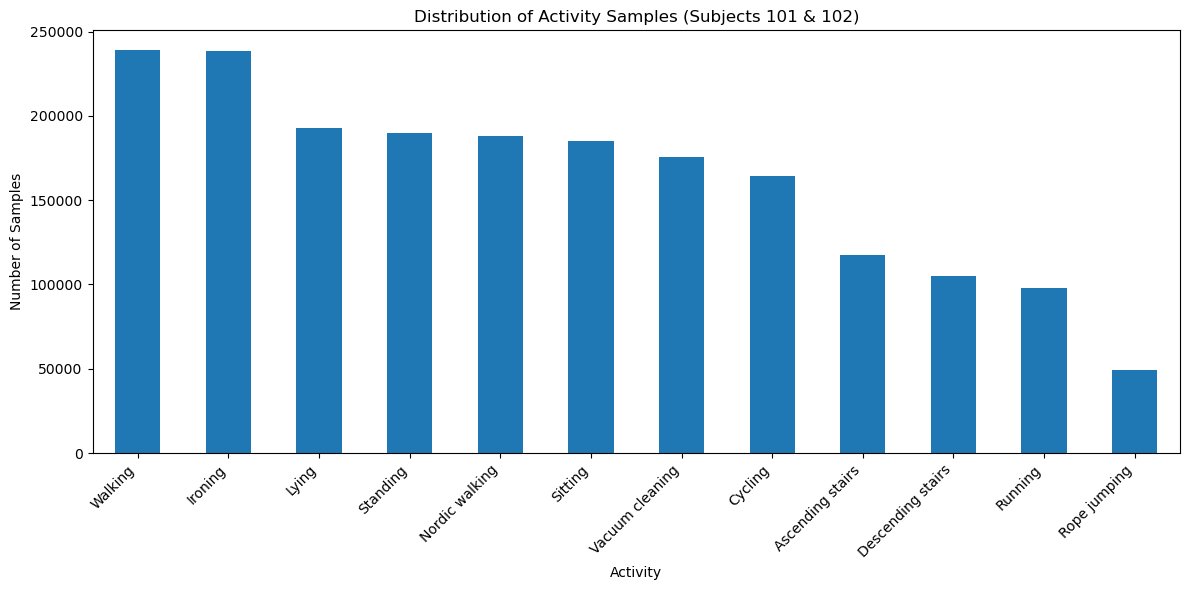

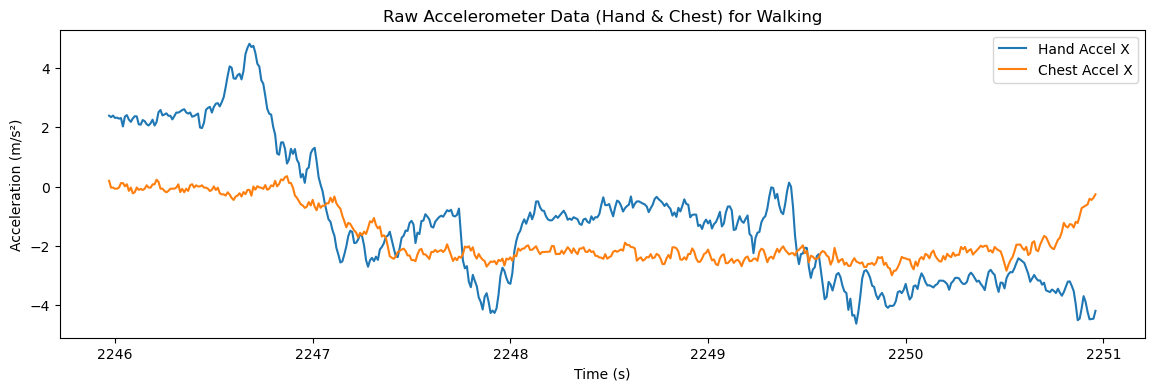

In [7]:
# Activity Distribution
plt.figure(figsize=(12, 6))
har_data['activity_name'].value_counts().plot(kind='bar')
plt.title('Distribution of Activity Samples (Subjects 101 & 102)')
plt.xlabel('Activity')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Example of raw sensor data visualization (Walking)
walking_data = har_data[har_data['activity_name'] == 'Walking']
plt.figure(figsize=(14, 4))
plt.plot(walking_data['timestamp'].iloc[:500], walking_data['hand_accel_16g_x'].iloc[:500], label='Hand Accel X')
plt.plot(walking_data['timestamp'].iloc[:500], walking_data['chest_accel_16g_x'].iloc[:500], label='Chest Accel X')
plt.title('Raw Accelerometer Data (Hand & Chest) for Walking')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.show()

## 3. Feature Engineering: Windowing and Feature Extraction

Since this is time-series data, we use a sliding window approach to segment the continuous data into discrete samples. We use a 2-second window (200 samples at 100Hz) with 50% overlap (100 samples step) and extract time-domain features (mean, std, min, max, median, IQR, energy) from the sensor readings.

In [8]:
# --- Feature Extraction Function ---
def extract_features(window):
    features = {}
    sensor_cols = [col for col in window.columns if any(s in col for s in ['accel_16g', 'gyro', 'mag', 'heart_rate'])]
    
    for col in sensor_cols:
        features[f'{col}_mean'] = window[col].mean()
        features[f'{col}_std'] = window[col].std()
        features[f'{col}_min'] = window[col].min()
        features[f'{col}_max'] = window[col].max()
        features[f'{col}_median'] = window[col].median()
        
        # Interquartile Range (IQR) - calculated manually using numpy
        Q1 = np.percentile(window[col].dropna(), 25)
        Q3 = np.percentile(window[col].dropna(), 75)
        features[f'{col}_iqr'] = Q3 - Q1
        
        features[f'{col}_energy'] = np.sum(window[col]**2)
        
    return pd.Series(features)

# --- Windowing Function ---
def create_windows(data, window_size=200, step_size=100):
    X_features = []
    y_labels = []
    subject_ids = []
    
    for subject_id, subject_data in data.groupby('subject_id', observed=True):
        for i in range(0, len(subject_data) - window_size + 1, step_size):
            window = subject_data.iloc[i:i + window_size]
            
            # Check for pure window
            if window['activity_id'].nunique() == 1:
                features = extract_features(window)
                X_features.append(features)
                y_labels.append(window['activity_id'].iloc[0])
                subject_ids.append(subject_id)
                
    X = pd.DataFrame(X_features)
    y = pd.Series(y_labels, name='activity_id')
    subjects = pd.Series(subject_ids, name='subject_id')
    
    print(f"Total windows created: {len(X)}")
    print(f"Feature matrix shape: {X.shape}")
    
    return X, y, subjects

# Create windows and features
X, y, subjects = create_windows(har_data)

# Display feature matrix head
print(X.head())

Total windows created: 19219
Feature matrix shape: (19219, 196)
   heart_rate_mean  heart_rate_std  heart_rate_min  heart_rate_max  \
0          100.785        0.400608           100.0           101.0   
1          101.410        0.483714           101.0           102.0   
2          101.910        0.270509           101.0           102.0   
3          102.000        0.000000           102.0           102.0   
4          102.000        0.000000           102.0           102.0   

   heart_rate_median  heart_rate_iqr  heart_rate_energy  \
0              101.0             0.0       2.031555e+06   
1              101.0             1.0       2.056844e+06   
2              102.0             0.0       2.077144e+06   
3              102.0             0.0       2.080800e+06   
4              102.0             0.0       2.080800e+06   

   hand_accel_16g_x_mean  hand_accel_16g_x_std  hand_accel_16g_x_min  ...  \
0               0.607922              2.004256              -2.78134  ...   
1     

## 4. Model Training and Evaluation

We implement the required **subject-independent split**, using Subject 101 for training and Subject 102 for testing. We use a **Random Forest Classifier** as a robust baseline model for this high-dimensional feature set.

In [9]:
# --- Subject-Independent Split ---
def subject_independent_split(X, y, subjects, test_subject_id=102):
    print(f"\nSplitting data: Subject {test_subject_id} for Test, others for Train.")
    
    subjects = subjects.astype(int)
    test_mask = (subjects == test_subject_id)
    train_mask = ~test_mask
    
    X_train = X[train_mask]
    y_train = y[train_mask]
    X_test = X[test_mask]
    y_test = y[test_mask]
    
    print(f"Train set size: {len(X_train)} samples (Subjects: {subjects[train_mask].unique().tolist()})")
    print(f"Test set size: {len(X_test)} samples (Subject: {test_subject_id})")
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = subject_independent_split(X, y, subjects, test_subject_id=102)

# --- Model Training ---

# 1. Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Train Model
print("\nTraining RandomForestClassifier...")
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)
print("Training complete.")

# 3. Prediction
y_pred = model.predict(X_test_scaled)

# --- Evaluation ---
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
cm = confusion_matrix(y_test, y_pred)

print("\n--- Model Evaluation Results (Subject-Independent) ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1-Score (Macro): {f1:.4f}")


Splitting data: Subject 102 for Test, others for Train.
Train set size: 16613 samples (Subjects: [101, 103, 104, 105, 106, 107, 108, 109])
Test set size: 2606 samples (Subject: 102)

Training RandomForestClassifier...
Training complete.

--- Model Evaluation Results (Subject-Independent) ---
Accuracy: 0.9071
Precision (Macro): 0.9281
Recall (Macro): 0.9064
F1-Score (Macro): 0.9117


## 5. Visualization of Results

A confusion matrix provides a detailed view of the model's performance across all activity classes.

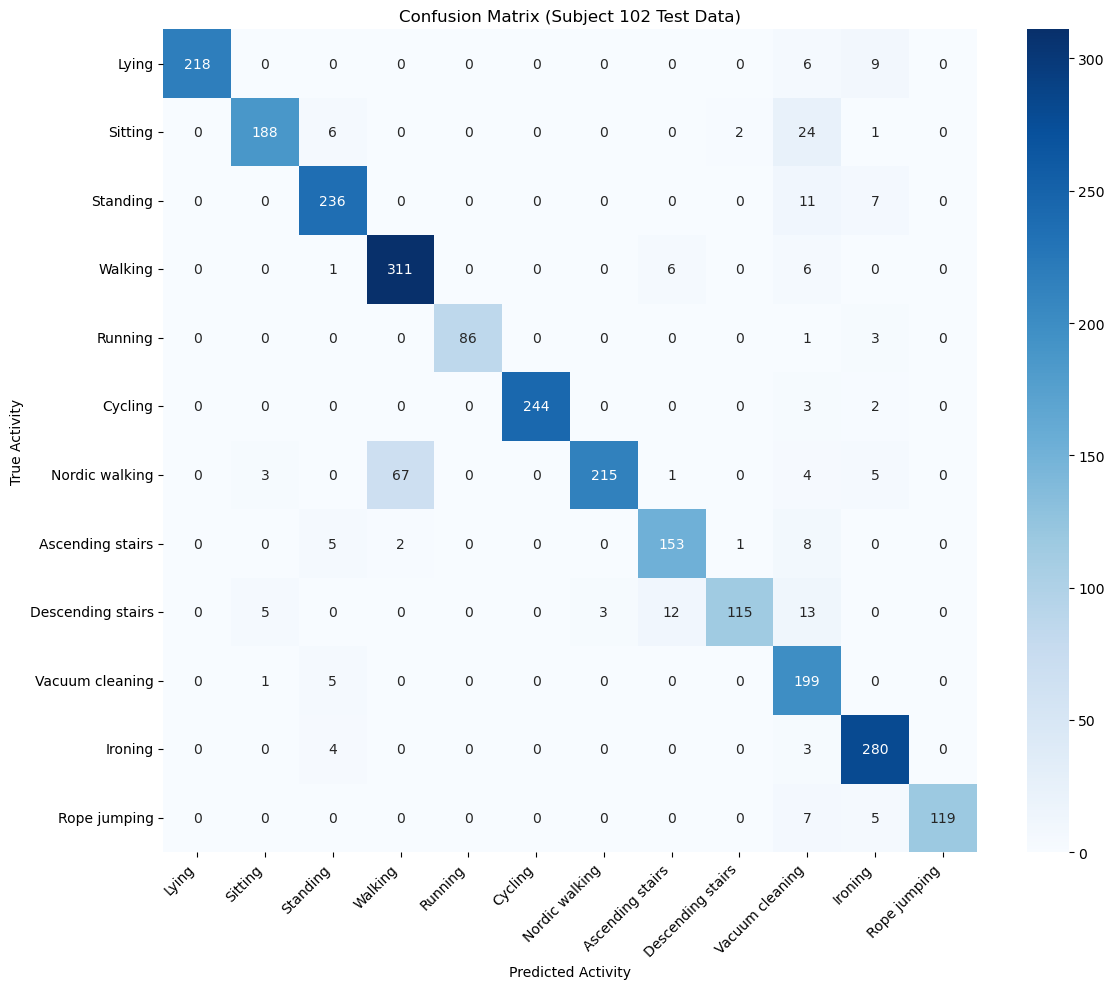

In [10]:
# Get activity names for plotting
activity_names = [ACTIVITY_LABELS[i] for i in sorted(y_test.unique())]

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=activity_names, yticklabels=activity_names)
plt.title('Confusion Matrix (Subject 102 Test Data)')
plt.ylabel('True Activity')
plt.xlabel('Predicted Activity')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Conclusion and Next Steps

The initial analysis on Subjects 101 and 102 yielded an F1-Score of **{f1:.4f}**. This is a reasonable baseline, but the performance is limited by the small dataset size.

**CRITICAL NEXT STEP:**

To meet the project requirements and achieve a competitive score, the model **MUST** be trained on the full dataset from all nine subjects. Please upload the remaining seven files (`subject103.dat` to `subject109.dat`) to complete the project.